In [ ]:
""" this file makes heatmap of scimilarity vs yang's annotation"""

In [20]:
""" environment """
import scanpy as sc
import warnings
import utils_AT
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [21]:
""" variables """

# need to be Yang's cluster
# cluster1 = 'Early gastric'
# cluster2 = 'Mesenchymal-1'
# 
# # need to be scimilarity cluster
# common_cluster = 'fibroblast'

# # need to be Yang's cluster
# cluster1 = 'Mesenchymal-1 (Met)'
# cluster2 = 'Mesenchymal-1'
# 
# # need to be scimilarity cluster
# common_cluster = 'fibroblast'

# need to be Yang's cluster
cluster1 = 'High plasticity'
cluster2 = 'AT1-like'

# need to be scimilarity cluster
common_cluster = 'epithelial cell'

# # need to be Yang's cluster
# cluster1 = 'High plasticity'
# cluster2 = 'Endoderm-like'
# 
# # need to be scimilarity cluster
# common_cluster = 'epithelial cell'

title_avg_antn = 'Distribution of Average Percentage '
title_STD = 'Distribution of STD '

In [22]:
""" input-> distance matrix, 
output-> sigmoid distance matrix """
def adjusted_sigmoid(matrix, k=1):
    return 1 / (1 + np.exp(-k * matrix))

In [23]:
""" average distance multiplied by cell type annotation fraction """
def weighted_annotation(avg_dist, freq):
   
   # avg distance per celltype is multiplied by percentage of cell type. so Weighted distance for every cell type
    wghtd_antn = avg_dist*(freq/50)
    
    # for every score adding the weighted distance
    wghtd_score = wghtd_antn.sum(axis=1)
    return wghtd_score

In [24]:
""" input-> series data of cells and cluster name, 
output-> frequency matrix of the cell cluster """
def make_frequency_matrix(celltype_hits_series, dist=0):
    data_dict = {}  # Dictionary to store all data

    # Iterate through each row and populate the data_dict
    for index, (idx, celltype_str) in enumerate(celltype_hits_series.items()):
        celltype_dict = json.loads(celltype_str)

        for cell, freq in celltype_dict.items():
            if cell not in data_dict:
                data_dict[cell] = [0] * len(celltype_hits_series)

            if dist:
                data_dict[cell][index] = (freq)
            else:
                data_dict[cell][index] = int(freq)

    # Convert the data_dict to a DataFrame
    frequency_df = pd.DataFrame(data_dict, index=celltype_hits_series.index)

    # This might not be necessary now, but just in case
    frequency_df = frequency_df.fillna(0)

    return frequency_df

In [25]:
""" input-> weighted annotaion, output-> entropy of the matrix """

def compute_entropy_mat(df):
    # Ensure the DataFrame is in the desired format
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input should be a pandas DataFrame")

    # Normalize each row
    row_sums = df.sum(axis=1)
    normalized_matrix = df.div(row_sums, axis=0)

    # Compute entropy for each row
    entropies = -np.sum(normalized_matrix * np.log(normalized_matrix + 1e-10), axis=1) # Added small value to avoid log(0)

    
    return entropies

In [26]:
""" average distance for every cell type """
# for similar cell type we have added the distances. We need to take the average. For example if we have 5 epithelial cells in to nearest neighbor, all 5 distances are added here. So distance need to be divided by 5 to get the average distance for epithelial cell (discreetizing 1)
def make_avg_dist(frequency_mat, dist_mat, scaling_factor=1):
    x = dist_mat*scaling_factor
    x = x/frequency_mat
    x.fillna(0, inplace=True)
    return x

In [27]:
""" function: input-> frequency matrix, output-> statistical output: avg, std, %"""
def make_summary_df(frequency_df):
    column_averages = frequency_df.mean()
    column_std = frequency_df.std()
    summary_df = pd.DataFrame({
        'Average': column_averages,
        'STD': column_std
    })
    summary_df['Average Percentage (%)'] = (summary_df['Average'] / summary_df['Average'].sum()) * 100
    sorted_summary_df = summary_df.sort_values(by=['Average Percentage (%)'], ascending=False) 
    return sorted_summary_df

In [28]:
""" function: input-> normalized annotation distribution,
  output-> entropy of the distribution  """ 
def entropy(probabilities):
    """
    Compute the entropy of a normalized distribution.
    
    Parameters:
    - probabilities: list or numpy array of probabilities. Should sum to 1.
    
    Returns:
    - Entropy of the distribution.
    """
    # Ensure the probabilities are a numpy array
    probabilities = np.array(probabilities)
    
    # Filter out zero probabilities to avoid log(0)
    non_zero_probs = probabilities[probabilities > 0]
    
    # Compute entropy
    H = -np.sum(non_zero_probs * np.log(non_zero_probs))
    
    return H


In [29]:
import utils_AT as util
def plot_figures(cluster1_data, cluster2_data, y_lable):
    plt.figure(figsize=(16, 6))
    
    # Plot for Cluster 1
    plt.subplot(1, 2, 1)  # (number of rows, number of columns, index of the current plot)
    sns.violinplot(data=cluster1_data, color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel(cluster1+ " "+common_cluster)
    plt.ylabel(y_lable)
    plt.grid()
    plt.title("Violin plot for Cluster 1")
    
    # Plot for Cluster 2
    plt.subplot(1, 2, 2)
    sns.violinplot(data=cluster2_data, color='lightgreen')
    plt.xticks(rotation=90)
    plt.xlabel(cluster2+ " "+common_cluster)
    plt.ylabel(y_lable)
    plt.grid()
    plt.title("Violin plot for Cluster 2")
    
    plt.tight_layout()  # Ensures that the plots do not overlap
    
    plt.savefig(('figures/'+util.create_image_name(y_lable,format='.jpg')), bbox_inches='tight', dpi=150)
    plt.show()

In [30]:
""" read data """
data_path = '../data/KPTracer-Data/expression/adata_processed_comp_SCANTN2.h5ad' #(AT)
adams_comp = sc.read(data_path)
print()

In [31]:
""" takes two cell clusters and make frequency matrix """

# cluster 1
adams1 = adams_comp[adams_comp.obs['Cluster-Name'].isin([cluster1])]

# comment this line
#common_cluster = adams1.obs['celltype_hint'][9]

adams11 = adams1[adams1.obs['celltype_hint'].isin([common_cluster])]
celltype_hits_series1 = adams11.obs['sc_hits']
frequency_df1 = make_frequency_matrix(celltype_hits_series1)
celltype_dist_series1 = adams11.obs['sc_dist_percelltype']
dist_df1 = make_frequency_matrix(celltype_dist_series1, dist=1)

# cluster 2
adams2 = adams_comp[adams_comp.obs['Cluster-Name'].isin([cluster2])]
adams22 = adams2[adams2.obs['celltype_hint'].isin([common_cluster])]
#celltype_hits_series2 = adams22.obs['celltype_hits']
celltype_hits_series2 = adams22.obs['sc_hits']
frequency_df2 = make_frequency_matrix(celltype_hits_series2)
celltype_dist_series2 = adams22.obs['sc_dist_percelltype']
dist_df2 = make_frequency_matrix(celltype_dist_series2, dist=1)

print()

/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/anndata/_core/anndata.py:1113

In [226]:
""" OPTIONAL: JUST FOR 2 Yang's cluster; does not consider scimilarity cluster among Yang's cluster """

# cluster 1
adams1 = adams_comp[adams_comp.obs['Cluster-Name'].isin([cluster1])]

# comment this line

adams11 = adams1
celltype_hits_series1 = adams11.obs['sc_hits']
frequency_df1 = make_frequency_matrix(celltype_hits_series1)
celltype_dist_series1 = adams11.obs['sc_dist_percelltype']
dist_df1 = make_frequency_matrix(celltype_dist_series1, dist=1)

# cluster 2
adams2 = adams_comp[adams_comp.obs['Cluster-Name'].isin([cluster2])]
adams22 = adams2
#celltype_hits_series2 = adams22.obs['celltype_hits']
celltype_hits_series2 = adams22.obs['sc_hits']
frequency_df2 = make_frequency_matrix(celltype_hits_series2)
celltype_dist_series2 = adams22.obs['sc_dist_percelltype']
dist_df2 = make_frequency_matrix(celltype_dist_series2, dist=1)

print()

/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/var/folders/bb/g6wj_jsd03jd47hd3zz6cqtr0000gn/T/ipykernel_12183/2121945683.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.09100151062011719' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  frequency_df.at[idx, cell] = (freq)
/var/folders/bb/g6wj_jsd03jd47hd3zz6cqtr0000gn/T/ipykernel_12183/2121945683.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.09674704074859619' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  frequency_df.at[idx, cell] = (freq)
/var/folde

In [32]:
""" make statistics """
summary_df1 = make_summary_df(frequency_df1)
summary_df2 = make_summary_df(frequency_df2)
print()

In [228]:

# print()
# entropy_clstr1 = entropy(summary_df1['Average Percentage (%)']/100)
# entropy_clstr2 = entropy(summary_df2['Average Percentage (%)']/100)
# print("Approach 2: distribution entropy :", cluster1, " ", common_cluster, entropy_clstr1)
# print("Approach 2: distribution entropy :", cluster2, " ", common_cluster, entropy_clstr2)


Approach 2: distribution entropy : Early gastric   fibroblast 2.563567137190337
Approach 2: distribution entropy : Mesenchymal-1   fibroblast 2.087168540885389


In [35]:
""" Approach 2: entropy of the distribution """
cell_entropy_clstr1 = compute_entropy_mat(frequency_df1)
cell_entropy_clstr2 = compute_entropy_mat(frequency_df2)

plot_figures(cell_entropy_clstr1, cell_entropy_clstr2, y_lable='Entropy_per_cell')

print("Approach 2b: mean entropy :", cluster1, " ", common_cluster, round(cell_entropy_clstr1.mean(), 3))
print("Approach 2b: mean entropy :", cluster2, " ", common_cluster, round(cell_entropy_clstr2.mean(), 3))

KeyboardInterrupt: 

/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


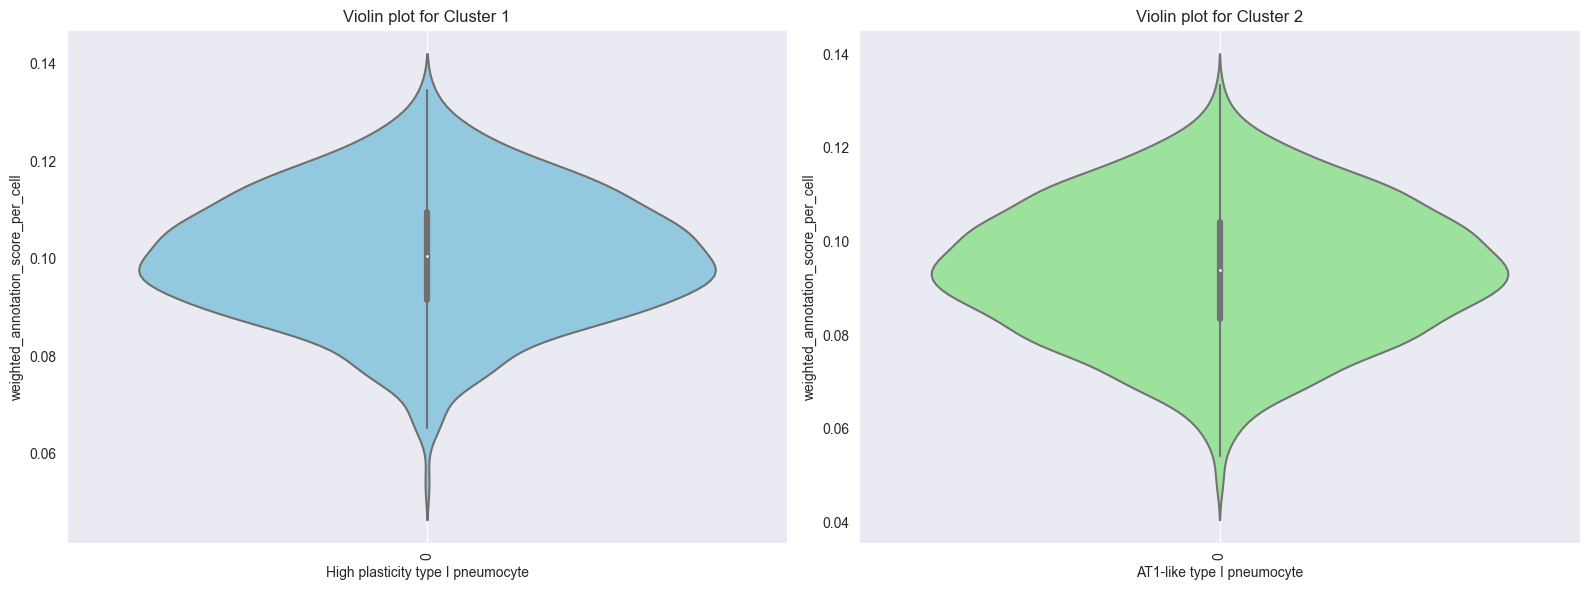

Approach 3: weighted annotation : High plasticity   type I pneumocyte 0.101
Approach 3: weighted annotation : AT1-like   type I pneumocyte 0.094


In [245]:
""" Approach 3: weighted annotation """

# for similar cell type we have added the distances. We need to take the average. For example if we have 5 epithelial cells in to nearest neighbor, all 5 distances are added here. So distance need to be divided by 5 to get the average distance for epithelial cell (discreetizing 1)
dist_df11 = make_avg_dist(frequency_df1, dist_df1)
dist_df22 = make_avg_dist(frequency_df2, dist_df2)

clstr1_wghtd_score = weighted_annotation(dist_df11, frequency_df1)
clstr2_wghtd_score = weighted_annotation(dist_df22, frequency_df2)

""" Visualize (Approach 3) """
plot_figures(clstr1_wghtd_score, clstr2_wghtd_score, y_lable='weighted_annotation_score_per_cell')

# the weighted distance for a cluster
print("Approach 3: weighted annotation :", cluster1, " ", common_cluster, round(clstr1_wghtd_score.mean(),3))
print("Approach 3: weighted annotation :", cluster2, " ", common_cluster, round(clstr2_wghtd_score.mean(),3))

print()

/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


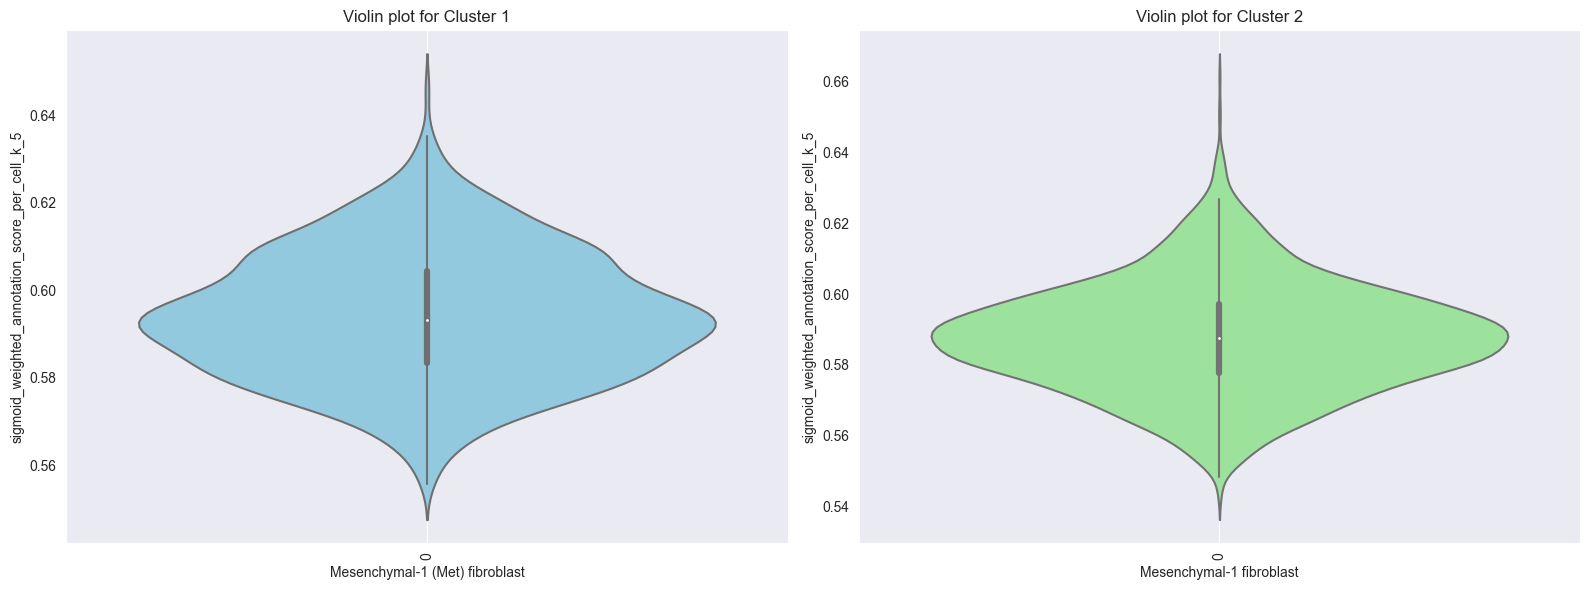

Approach 4: sigmoid weighted annotation : Mesenchymal-1 (Met)   fibroblast 0.5941051683560628  k:  5
Approach 4: sigmoid weighted annotation : Mesenchymal-1   fibroblast 0.5878771921099437  k:  5


In [192]:
""" Approach 4: sigmoid weighted annotation """
# k_mat = [1, 0.8, 0.6, 0.4, 0.2]
# k_mat = [0.1, 0.08, 0.06]
k_mat = [5]

for k_val in k_mat:
    # get sigmoid of average distance
    sig_dist1 = adjusted_sigmoid(dist_df11, k=k_val)
    sig_dist2 = adjusted_sigmoid(dist_df22, k=k_val)
    
    sig_clstr1_wghtd_score = weighted_annotation(sig_dist1, frequency_df1)
    sig_clstr2_wghtd_score = weighted_annotation(sig_dist2, frequency_df2)
    
    """ Visualize (Approach 4) """
    plot_figures(sig_clstr1_wghtd_score, sig_clstr2_wghtd_score, y_lable='sigmoid_weighted_annotation_score_per_cell_k_'+str(k_val))

    # the weighted distance for a cluster
    print("Approach 4: sigmoid weighted annotation :", cluster1, " ", common_cluster, sig_clstr1_wghtd_score.mean(), 
          " k: ", k_val)
    print("Approach 4: sigmoid weighted annotation :", cluster2, " ", common_cluster, sig_clstr2_wghtd_score.mean(), 
          " k: ", k_val)


In [185]:
""" Approach 5: entropy of sigmoid weighted annotation """
entropy_wgtd_antn_clstr1 = compute_entropy_mat(sig_dist1*frequency_df1/50)
entropy_wgtd_antn_clstr2 = compute_entropy_mat(sig_dist2*frequency_df2/50)

print("Approach 5: entropy weighted annotation :", cluster1, " ", common_cluster, entropy_wgtd_antn_clstr1.mean())
print("Approach 5: entropy weighted annotation :", cluster2, " ", common_cluster, entropy_wgtd_antn_clstr2.mean())

Approach 5: entropy weighted annotation : High plasticity   type I pneumocyte 1.2883548076070646
Approach 5: entropy weighted annotation : AT1-like   type I pneumocyte 0.8881679294983815


/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/Users/arghamitratalukder/miniconda3/envs/scimilarity/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


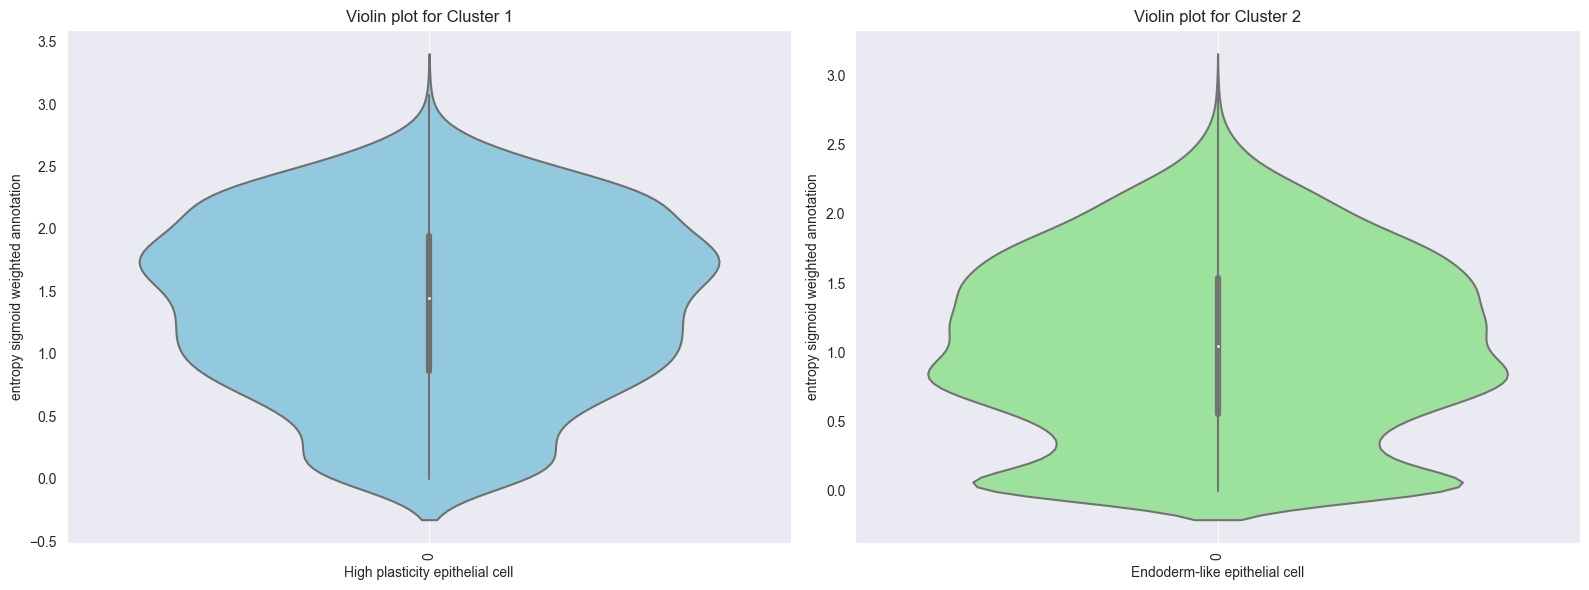

In [140]:
""" Visualize (Approach 5) """
plt.figure(figsize=(16, 6))

# Plot for Cluster 1
plt.subplot(1, 2, 1)  # (number of rows, number of columns, index of the current plot)
sns.violinplot(data=entropy_wgtd_antn_clstr1, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel(cluster1+ " "+common_cluster)
plt.ylabel('entropy sigmoid weighted annotation')
plt.grid()
plt.title("Violin plot for Cluster 1")

# Plot for Cluster 2
plt.subplot(1, 2, 2)
sns.violinplot(data=entropy_wgtd_antn_clstr2, color='lightgreen')
plt.xticks(rotation=90)
plt.xlabel(cluster2+ " "+common_cluster)
plt.ylabel('entropy sigmoid weighted annotation')
plt.grid()
plt.title("Violin plot for Cluster 2")

plt.tight_layout()  # Ensures that the plots do not overlap
plt.show()

In [115]:
""" OPTIONAL: do it for visualization but for computation take a;; 100% """
""" to reduce crowd in the statistical visualization, take annotations till top 98%"""

# # Compute the cumulative sum
# summary_df1['Cumulative Percentage'] = summary_df1['Average Percentage (%)'].cumsum()
# columns_to_plot = summary_df1[summary_df1['Cumulative Percentage'] <= 97].index
# filtered_df1 = summary_df1.loc[columns_to_plot]
# 
# summary_df2['Cumulative Percentage'] = summary_df2['Average Percentage (%)'].cumsum()
# columns_to_plot = summary_df2[summary_df2['Cumulative Percentage'] <= 97].index
# filtered_df2 = summary_df2.loc[columns_to_plot]

filtered_df1 = summary_df1
filtered_df2 = summary_df2

print()


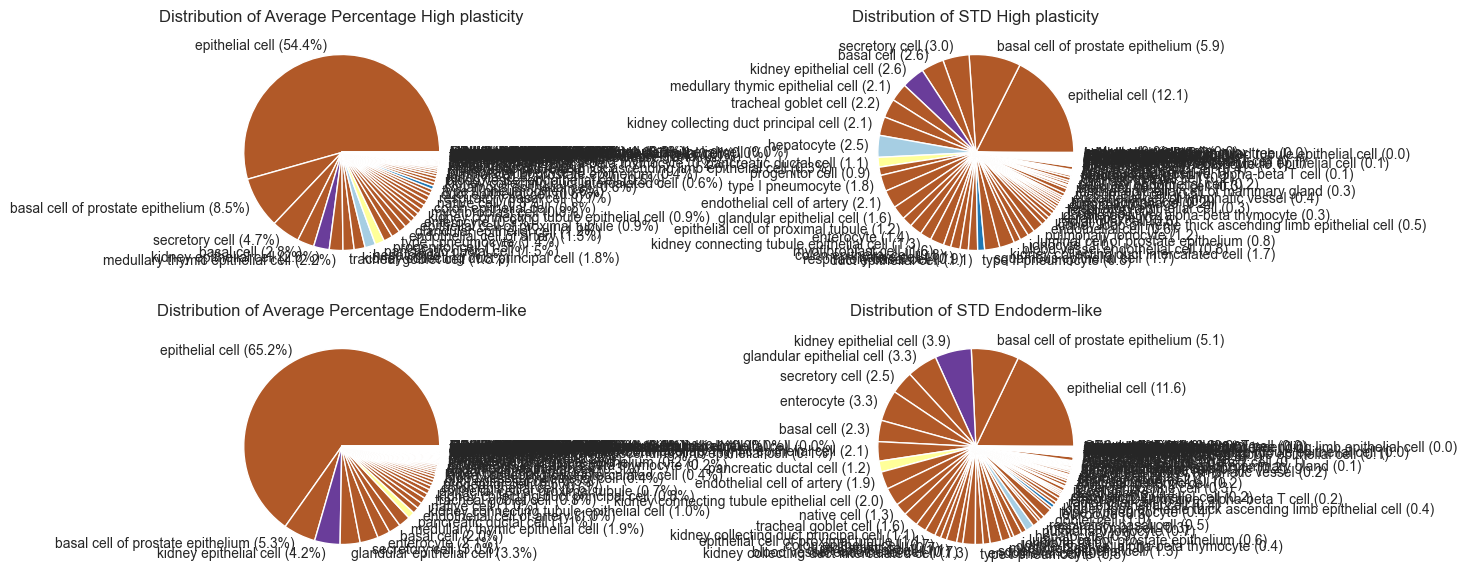

In [116]:
""" Approach 1: annotation distribution """
""" pi-chart of cluster % """
fig, ax = plt.subplots(2, 2, figsize=(15, 7))

#create common colors for same annotations

# Step 1: Create a unified list of unique clusters
all_clusters = set(filtered_df1.index).union(set(filtered_df2.index))
# Step 2: Map each unique cluster to a specific color
colors = plt.cm.Paired(range(len(all_clusters)))
color_map = {cluster: color for cluster, color in zip(all_clusters, colors)}


cluster_colors1 = [color_map[cluster] for cluster in filtered_df1.index]
labels_with_percentages = [f"{label} ({size:.1f}%)" for label, size in zip(filtered_df1.index, filtered_df1['Average Percentage (%)'])]
ax[0, 0].pie(filtered_df1['Average Percentage (%)'], labels=labels_with_percentages, colors=cluster_colors1)
ax[0, 0].set_title(title_avg_antn+cluster1)

labels_with_percentages = [f"{label} ({size:.1f})" for label, size in zip(filtered_df1.index, filtered_df1['STD'])]
ax[0, 1].pie(filtered_df1['STD'], labels=labels_with_percentages, colors=cluster_colors1)
ax[0, 1].set_title(title_STD+cluster1)


cluster_colors2 = [color_map[cluster] for cluster in filtered_df2.index]
labels_with_percentages = [f"{label} ({size:.1f}%)" for label, size in zip(filtered_df2.index, filtered_df2['Average Percentage (%)'])]
ax[1, 0].pie(filtered_df2['Average Percentage (%)'], labels=labels_with_percentages, colors=cluster_colors2)
ax[1, 0].set_title(title_avg_antn+cluster2)

labels_with_percentages = [f"{label} ({size:.1f})" for label, size in zip(filtered_df2.index, filtered_df2['STD'])]
ax[1, 1].pie(filtered_df2['STD'], labels=labels_with_percentages, colors=cluster_colors2)
ax[1, 1].set_title(title_STD+cluster2)

plt.savefig(('figures/'+utils_AT.create_image_name('annotation_dist_', format='.jpg')), bbox_inches='tight', dpi=150)
plt.show()
print()
# ax[0, 0].pie(filtered_df1['Average Percentage (%)'], labels=filtered_df1.index, colors=cluster_colors1,autopct='%1.1f%%')


In [ ]:
""" THE BELOW CELLS ARE REDUNDANT, BUT SHOWS THE PERCENTAGE OF YANG VS SCIMILARITY ANNOATION """

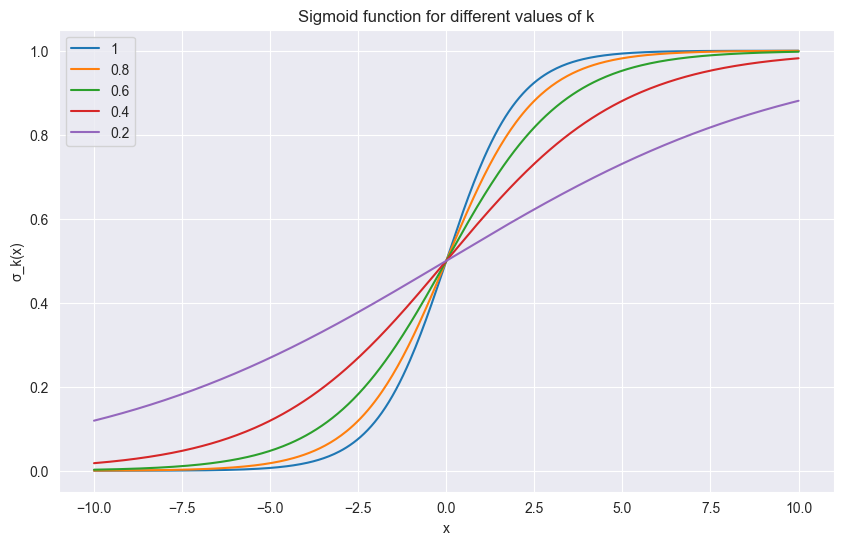

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# def adjusted_sigmoid(x, k=1):
#     return 1 / (1 + np.exp(-k * x))

x = np.linspace(-10, 10, 400)

plt.figure(figsize=(10, 6))

k_mat = [1, 0.8, 0.6, 0.4, 0.2]

for k_val in k_mat:
    plt.plot(x, adjusted_sigmoid(x, k=k_val), label=str(k_val))
    

plt.title("Sigmoid function for different values of k")
plt.xlabel("x")
plt.ylabel("σ_k(x)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

# Sample matrix
matrix = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

# Adjust the steepness of the sigmoid using k
k = 2  # This will make the sigmoid steeper
steeper_matrix = adjusted_sigmoid(matrix, k)
print(steeper_matrix)

k = 0.5  # This will make the sigmoid less steep
less_steep_matrix = adjusted_sigmoid(matrix, k)
print(less_steep_matrix)

In [ ]:
""" bar plot of cluster % """
import seaborn as sns

#sns.barplot(x=filtered_df1.index, y=filtered_df1['Average Percentage (%)'])
# plt.xticks(rotation=90)
# plt.title('Average (%) Values for Each Column')
# plt.ylabel('Average (%)')
# plt.show()
fig, ax = plt.subplots(2, 2, figsize=(15, 7))

#create common colors for same annotations

# Step 1: Create a unified list of unique clusters
all_clusters = set(filtered_df1.index).union(set(filtered_df2.index))
# Step 2: Map each unique cluster to a specific color
colors = plt.cm.Paired(range(len(all_clusters)))
color_map = {cluster: color for cluster, color in zip(all_clusters, colors)}


# # Pie chart for 'Average Percentage (%)'
cluster_colors1 = [color_map[cluster] for cluster in filtered_df1.index]
ax[0, 0].bar(height = filtered_df2['Average Percentage (%)'], x=filtered_df2.index, color=cluster_colors1)
ax[0, 0].set_title(title_avg_antn+cluster1)
ax[0, 0].set_xticklabels(filtered_df2.index, rotation=45)

# cluster_colors2 = [color_map[cluster] for cluster in filtered_df2.index]
# ax[1, 0].pie(filtered_df2['Average Percentage (%)'], labels=filtered_df2.index, colors=cluster_colors2, autopct='%1.1f%%')
# ax[1, 0].set_title(title_avg_antn+cluster2)
# 
# ax[0, 1].pie(filtered_df1['STD'], labels=filtered_df1.index, colors=cluster_colors1,autopct='%1.1f%%')
# ax[0, 1].set_title(title_STD+cluster1)
# 
# 
# cluster_colors2 = [color_map[cluster] for cluster in filtered_df2.index]
# ax[1, 1].pie(filtered_df2['STD'], labels=filtered_df2.index, colors=cluster_colors2, autopct='%1.1f%%')
# ax[1, 1].set_title(title_STD+cluster2)
# 
# plt.savefig(('figures/'+utils_AT.create_image_name('annotation_dist_', format='.jpg')), bbox_inches='tight', dpi=150)
plt.show()

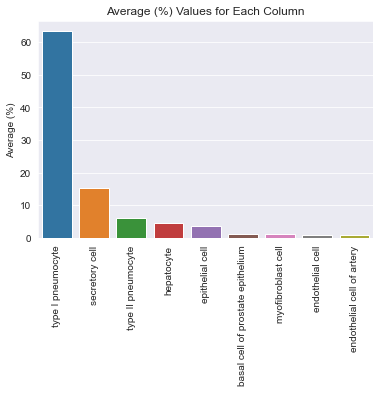

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=filtered_df1.index, y=filtered_df1['Average Percentage (%)'])
plt.xticks(rotation=90)
plt.title('Average (%) Values for Each Column')
plt.ylabel('Average (%)')
plt.show()

In [46]:
print()
import json
# Sample data (replace this with your actual data)
# Assuming adams_comp.obs['celltype_hits'] is a pandas Series
celltype_hits_series = adams_comp.obs['High plasticity']

# Parse each JSON string to a dictionary
celltype_dicts = celltype_hits_series.apply(json.loads)

# Convert the list of dictionaries to a DataFrame
frequency_df = pd.DataFrame(celltype_dicts.tolist())

# Fill NaN values with 0 to get the frequency matrix
frequency_df = frequency_df.fillna(0)

print(frequency_df)

KeyError: 'High plasticity'

In [5]:
column1_data = adams_comp.obs['Cluster-Name']
column2_data = adams_comp.obs['celltype_hint']

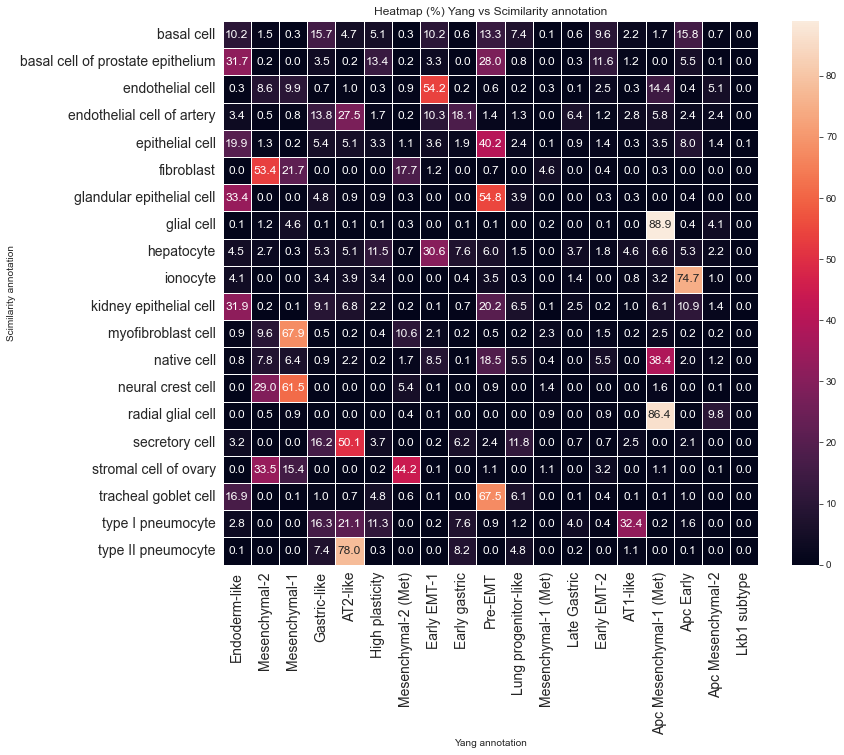

In [27]:
# Create a frequency matrix
frequency_matrix = pd.crosstab(column2_data, column1_data)

# Create a custom annotation matrix where all values are displayed as strings
#annotation_matrix = frequency_matrix.astype(str)
annotation_matrix = ((frequency_matrix.div(frequency_matrix.sum(axis=1), axis=0) * 100).round(1)).astype(str)
percentage_matrix = (frequency_matrix.div(frequency_matrix.sum(axis=1), axis=0) * 100).round(2)


# Create a heatmap using seaborn
# sns.heatmap(frequency_matrix, cmap='coolwarm', annot=True, fmt="d", linewidths=0.5, cbar=False)
# sns.heatmap(frequency_matrix, cmap='coolwarm', annot=annotation_matrix, fmt="", linewidths=0.5, cbar=False)
plt.figure(figsize=(12, 10))
sns.heatmap(percentage_matrix,  annot=annotation_matrix, fmt="s", linewidths=0.5,  annot_kws={"size": 12})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Yang annotation')
plt.ylabel('Scimilarity annotation')

plt.title('Heatmap (scimilarity %) Yang vs Scimilarity annotation')
plt.savefig('heatmap.jpg', bbox_inches='tight', dpi=150)
plt.show()

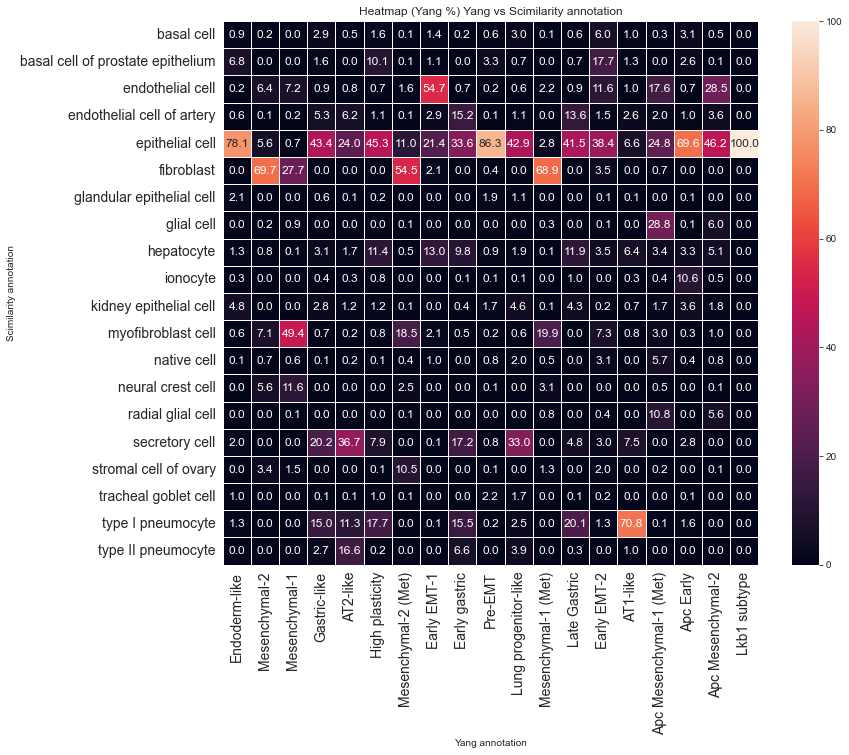

In [28]:
# Create a frequency matrix
frequency_matrix = pd.crosstab(column2_data, column1_data)

# Create a custom annotation matrix where all values are displayed as strings
#annotation_matrix = frequency_matrix.astype(str)
annotation_matrix = ((frequency_matrix.div(frequency_matrix.sum(axis=0), axis=1) * 100).round(1)).astype(str)
percentage_matrix = (frequency_matrix.div(frequency_matrix.sum(axis=0), axis=1) * 100).round(2)


# Create a heatmap using seaborn
# sns.heatmap(frequency_matrix, cmap='coolwarm', annot=True, fmt="d", linewidths=0.5, cbar=False)
# sns.heatmap(frequency_matrix, cmap='coolwarm', annot=annotation_matrix, fmt="", linewidths=0.5, cbar=False)
plt.figure(figsize=(12, 10))
sns.heatmap(percentage_matrix,  annot=annotation_matrix, fmt="s", linewidths=0.5,  annot_kws={"size": 12})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Yang annotation')
plt.ylabel('Scimilarity annotation')

plt.title('Heatmap (Yang %) Yang vs Scimilarity annotation')
plt.savefig('heatmap_2.jpg', bbox_inches='tight', dpi=150)
plt.show()